## Diabetes Patient Readmission Prediction Using ML

An investigation into factors that contribute to the readmission of patients with diabetes.

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Research Questions

1. What are the primary factors that contribute to patient readmission within 30 days?
2. Is there a correlation between age, race, and gender with readmission rates?
3. Does the length of hospital stay have an impact on the readmission of diabetes patients?
4. Are there any notable differences in readmission rates based on admission type and source?

### Data Analysis and Exploration

In [ ]:
# Read the dataset
diabetes_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Github/diabetes.csv")

In [ ]:
# Display the first few rows of the dataframe to understand its structure and contents
diabetes_data.head()

,id,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,1,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,...,No,No,No,No,No,No,No,No,No,NO
1,2,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,3,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,...,No,No,No,No,No,No,No,No,Yes,NO
3,4,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Data Preprocessing
# Identify missing values and summarize them for inspection
missing_values = diabetes_data.replace('?', pd.NA).isna().sum()

# Correct data formats and handle outliers
# For now, we will just convert some known categorical columns to the 'category' data type.
# Age is bracketed, so it's categorical even though it represents a numerical concept.
categorical_columns = ['race', 'gender', 'age', 'weight', 'change', 'diabetesMed', 'readmitted']
for col in categorical_columns:
    diabetes_data[col] = diabetes_data[col].astype('category')

In [ ]:
# Exploratory Data Analysis (EDA)
# Descriptive statistics
descriptive_stats = diabetes_data.describe(include='all')

In [ ]:
descriptive_stats

,id,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,101766.000000,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,NaN,6,3,10,10,NaN,NaN,NaN,...,1,4,4,2,2,2,2,2,2,3
top,NaN,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,50883.500000,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,29377.458084,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,25442.250000,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,50883.500000,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,76324.750000,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Descriptive Statistics
- There are 101,766 records in the dataset.
- Race is predominantly Caucasian, and the most frequent gender is Female.
- The age category most represented is [70-80).
- There are several columns with a single unique value, indicating no variation (such as citoglipton).
- Categorical variables like race, weight, payer_code, and medical_specialty have a notable amount of missing data.
- Numerical columns like admission_type_id, discharge_disposition_id, and admission_source_id are complete but are encoded as IDs, which likely correspond to categorical information.

In [ ]:
missing_values

,0
id,0
encounter_id,0
patient_nbr,0
race,2273
gender,0
age,0
weight,98569
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0


#### Missing Values

- race has 2,273 missing values.
- weight has a very high number of missing values (98,569), which may require this variable to be excluded from the analysis due to the high proportion of missing data.
- payer_code and medical_specialty also have a significant number of missing values (40,256 and 49,949, respectively).
- Diagnosis columns diag_1, diag_2, and diag_3 have some missing values but to a lesser extent.

Given the high number of missing values in certain columns, we might consider dropping these columns or imputing their values if they are crucial to the analysis. The weight column, for example, seems to have too many missing values to be useful.

Before proceeding with correlation analysis and data visualization, we need to decide how to handle these missing values. Given the context, it might be prudent to drop columns with excessive missing data that cannot be reliably imputed.

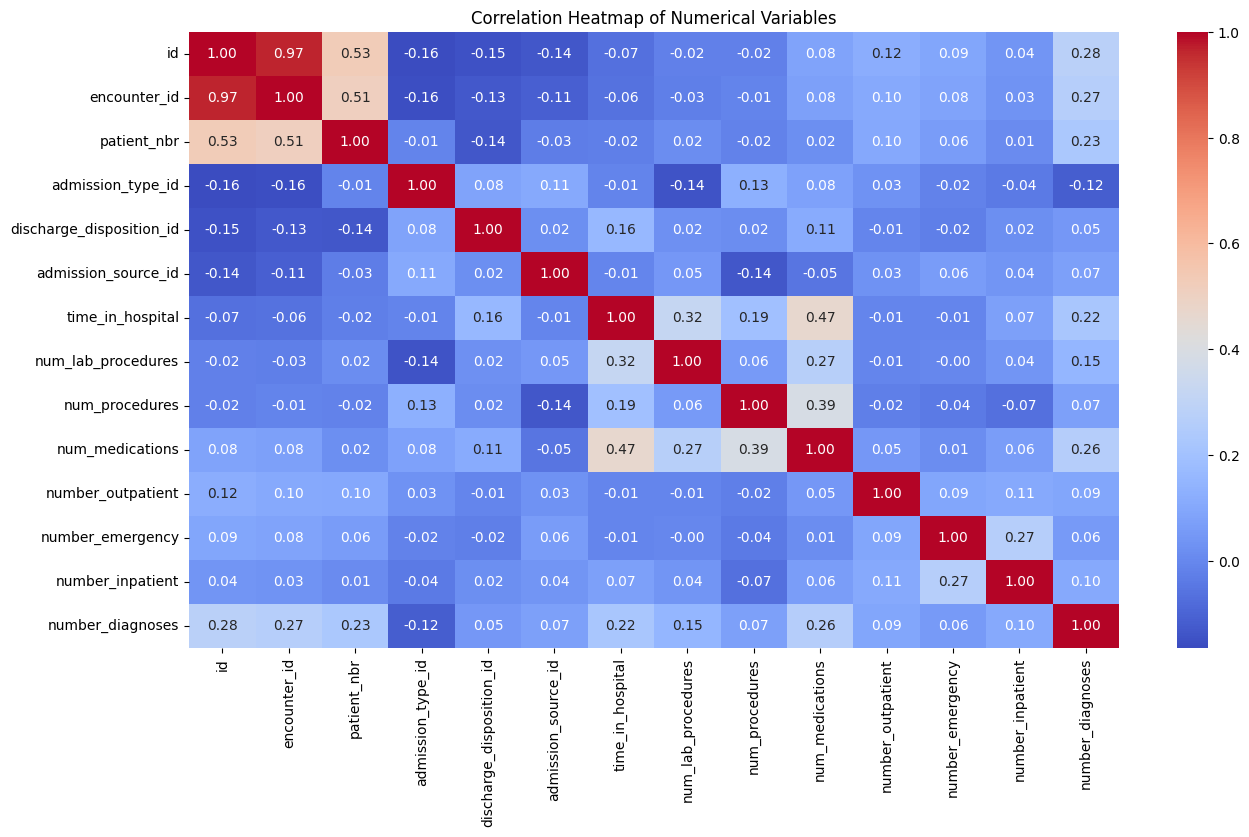

In [ ]:
# Due to the large amount of missing data, we will drop the 'weight' column.
# We will also drop 'payer_code' and 'medical_specialty' due to high missing values and for simplification.
diabetes_data_cleaned = diabetes_data.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

# For simplicity, we will drop rows with missing 'race' values.
diabetes_data_cleaned = diabetes_data_cleaned[diabetes_data_cleaned['race'].notna()]

diagnostics_columns = ['diag_1', 'diag_2', 'diag_3']
diabetes_data_cleaned[diagnostics_columns] = diabetes_data_cleaned[diagnostics_columns].fillna('Unknown')

# For the purpose of correlation analysis, we will only consider numerical columns.
numerical_columns = diabetes_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = diabetes_data_cleaned[numerical_columns].corr()

# Visualization: Correlation Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

The correlation heatmap shows the relationships between numerical variables in the dataset. The strongest correlations are likely to be between variables that directly influence one another or have a common cause.



- The heatmap indicates certain correlations, though most are not strong, which is typical for clinical datasets where many factors can be interrelated but not necessarily in a linear manner.
- There might be correlations between variables like the number of procedures and medications, which could be explored further to understand how these aspects of care relate to each other and to readmission rates.

In [ ]:
# Feature Engineering: Interaction and New Features
def add_interaction_features(df):
    """
    Adds interaction features and engineered columns to enhance predictive capability.
    """
    # Interaction between key numerical features
    df['age_lab_procedures'] = df['age'].cat.codes * df['num_lab_procedures']
    df['age_medications'] = df['age'].cat.codes * df['num_medications']
    df['hospital_stay_procedures'] = df['time_in_hospital'] * df['num_procedures']

    # Binary feature indicating extended hospital stay
    df['long_stay'] = (df['time_in_hospital'] > 7).astype(int)

    # Aggregated feature: total visits
    df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

    return df

# Apply feature engineering to the cleaned dataset
diabetes_data_cleaned = add_interaction_features(diabetes_data_cleaned)

# Verify new columns are added
print("New Columns in Dataset:")
print(diabetes_data_cleaned.columns)

New Columns in Dataset:
Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'age_lab_procedures', 'age_medications', 'hospital_stay_procedures',
       'long_stay', 'total_visits'],
      dtype='object')


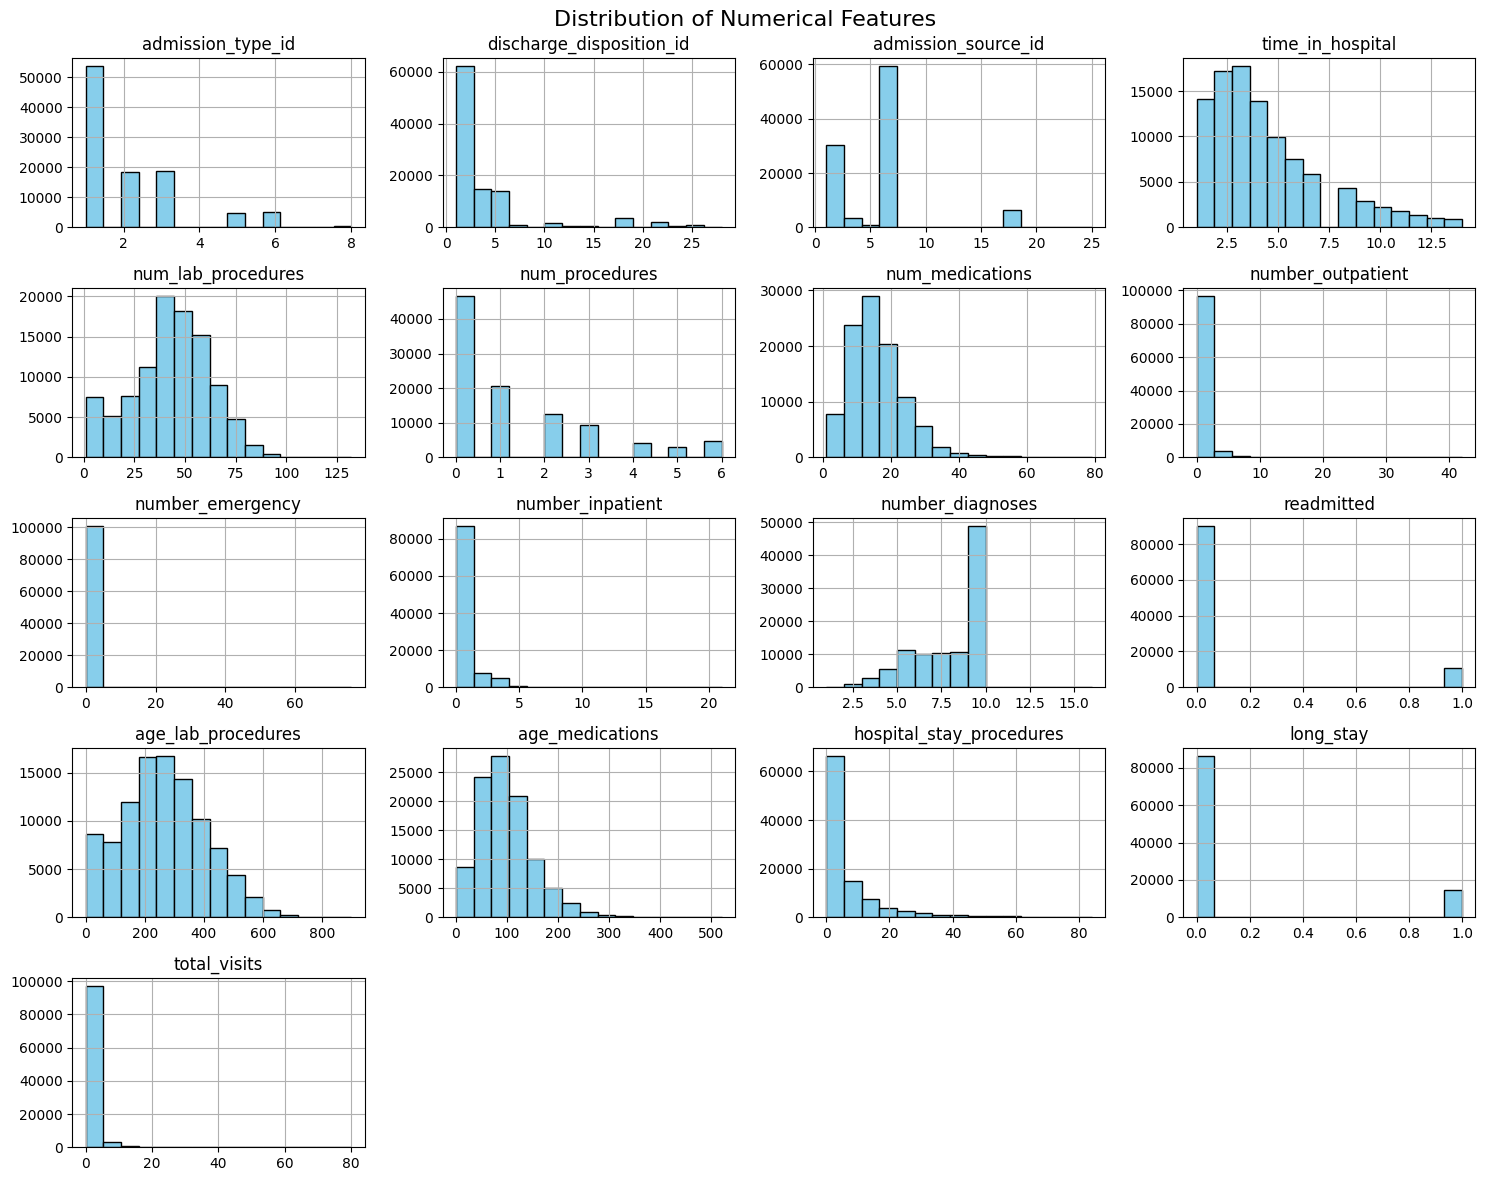

In [ ]:
# EDA: Distribution of Numerical Features
def plot_numerical_distributions(df, numerical_columns):
    """
    Plots histograms for numerical features.
    """
    df[numerical_columns].hist(bins=15, figsize=(15, 12), color='skyblue', edgecolor='black')
    plt.suptitle('Distribution of Numerical Features', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot the numerical distributions
numerical_columns = diabetes_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
plot_numerical_distributions(diabetes_data_cleaned, numerical_columns)

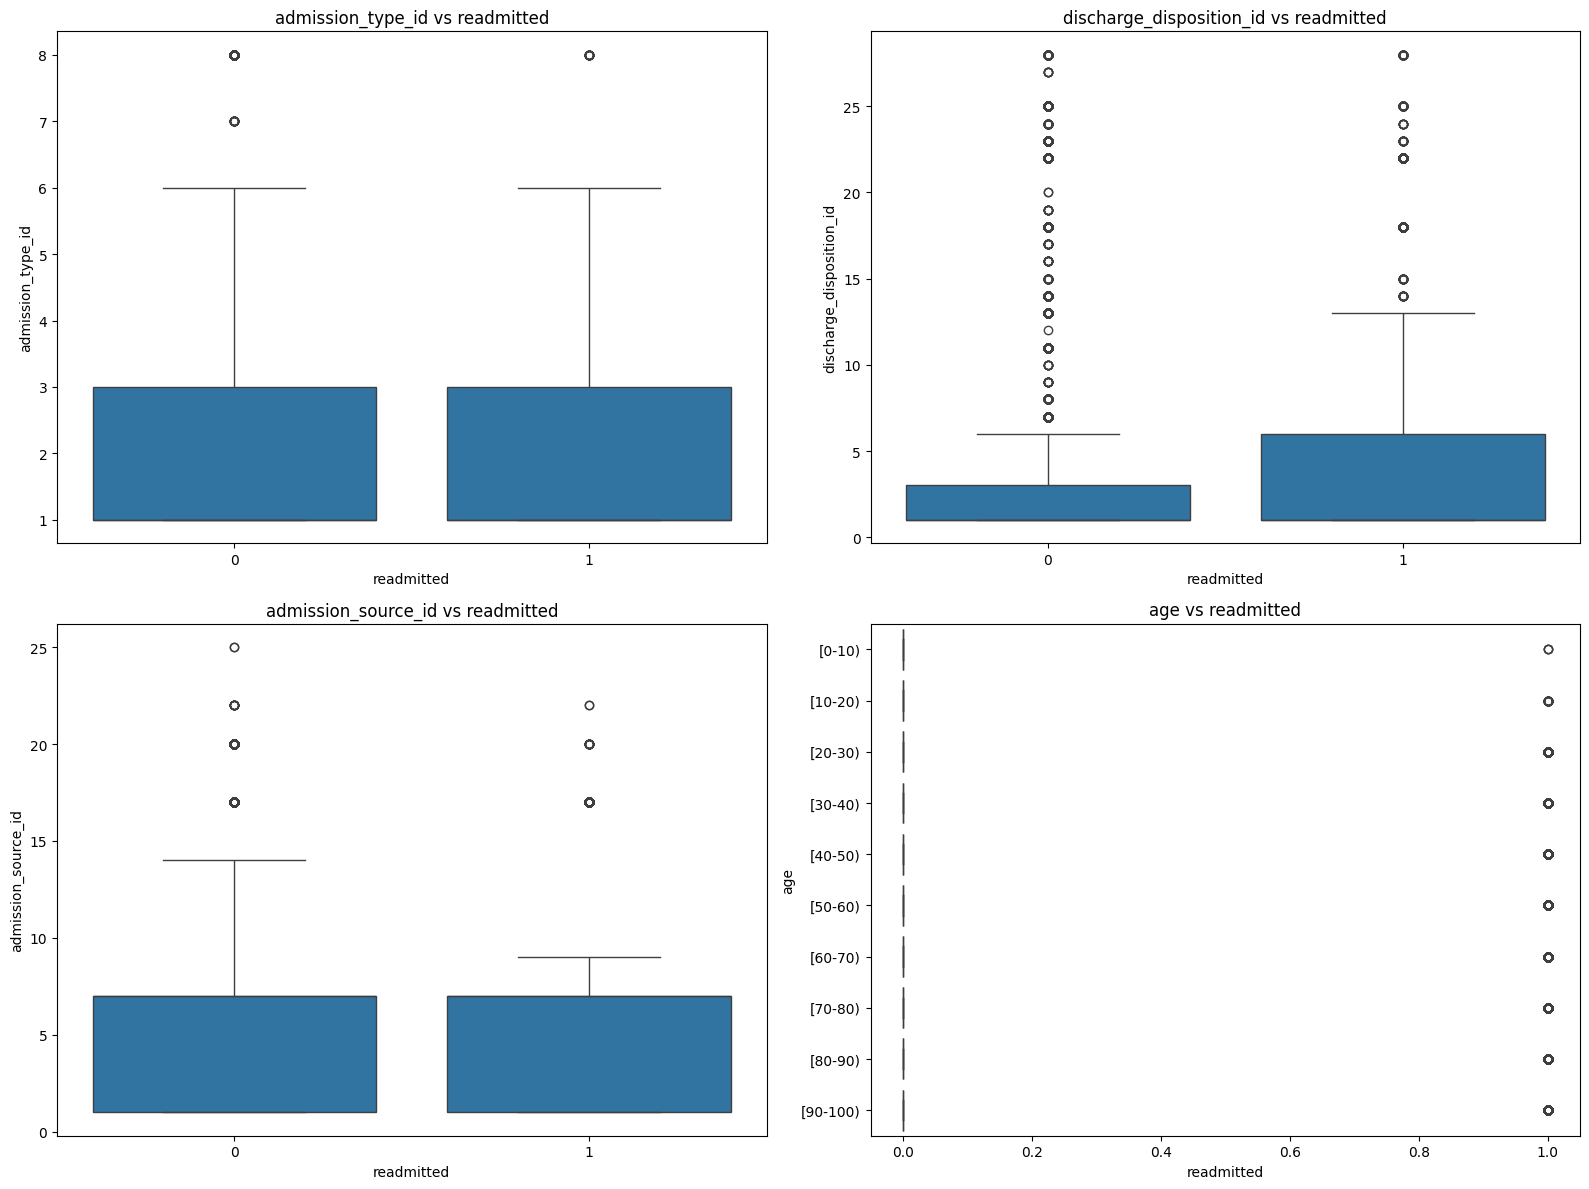

In [ ]:
# EDA: Boxplots for Categorical Features vs Target
def plot_boxplots(df, categorical_columns, target_column):
    """
    Plots boxplots for categorical features against the target variable.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, column in enumerate(categorical_columns[:4]):  # Limit to first 4 categorical features
        sns.boxplot(x=target_column, y=column, data=df, ax=axes[idx])
        axes[idx].set_title(f'{column} vs {target_column}')

    plt.tight_layout()
    plt.show()

# Select some categorical features
categorical_features = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'age']
plot_boxplots(diabetes_data_cleaned, categorical_features, 'readmitted')

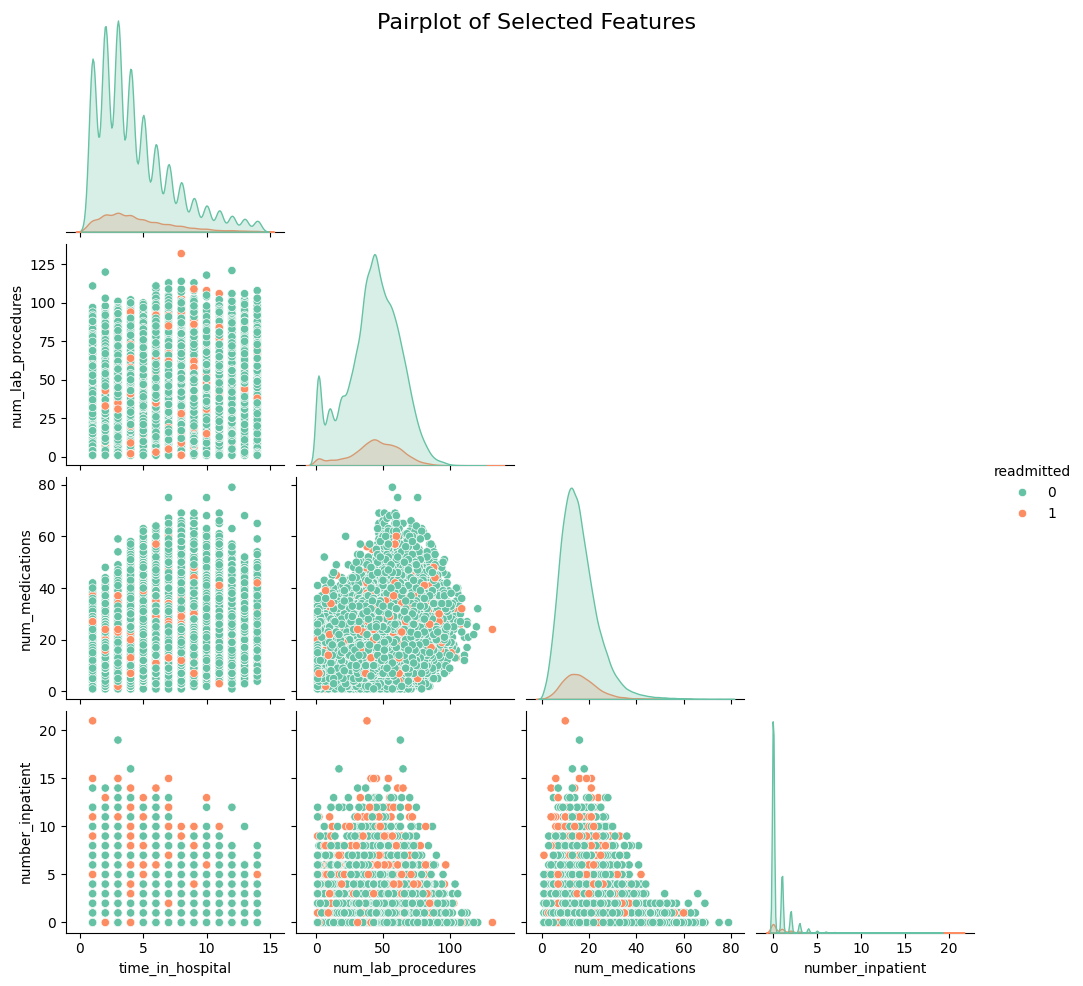

In [ ]:
# EDA: Pairplot for Important Features
def plot_pairplot(df, important_features):
    """
    Creates a pairplot for selected features to examine relationships.
    """
    sns.pairplot(df[important_features + ['readmitted']], hue='readmitted', palette='Set2', corner=True)
    plt.suptitle('Pairplot of Selected Features', fontsize=16)
    plt.show()

# Select important numerical features for pairplot
important_features = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_inpatient']
plot_pairplot(diabetes_data_cleaned, important_features)

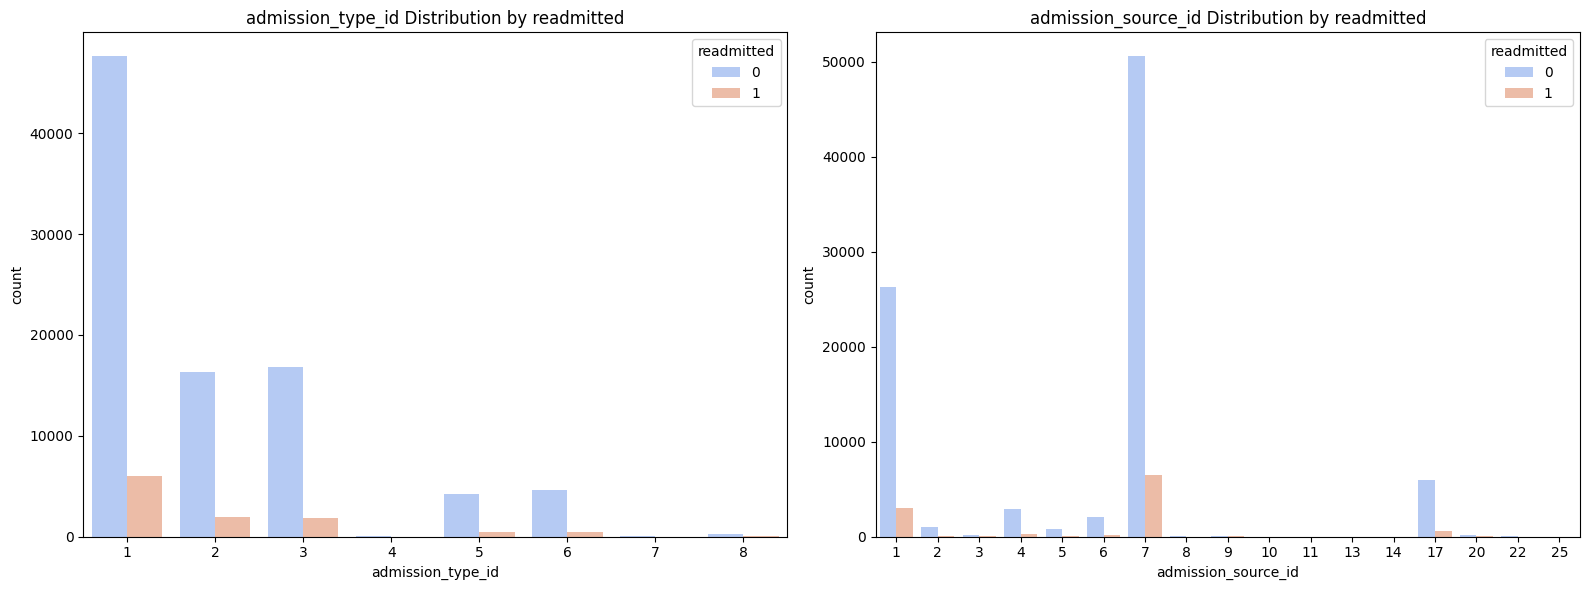

In [ ]:
# EDA: Countplot for Admission Type and Source
def plot_categorical_distributions(df, categorical_columns, target_column):
    """
    Plots countplots for categorical variables with respect to the target variable.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for idx, column in enumerate(categorical_columns):
        sns.countplot(x=column, hue=target_column, data=df, ax=axes[idx], palette='coolwarm')
        axes[idx].set_title(f'{column} Distribution by {target_column}')

    plt.tight_layout()
    plt.show()

# Select admission-related features
admission_features = ['admission_type_id', 'admission_source_id']
plot_categorical_distributions(diabetes_data_cleaned, admission_features, 'readmitted')

In [ ]:
from sklearn.ensemble import IsolationForest

def detect_and_remove_outliers(df, features, contamination=0.01):
    """
    Detects and removes outliers using Isolation Forest.

    Args:
    - df (pd.DataFrame): The dataset.
    - features (list): The features to consider for outlier detection.
    - contamination (float): Proportion of data to treat as outliers.

    Returns:
    - pd.DataFrame: Dataset with outliers removed.
    """
    # Initialize Isolation Forest
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    df['is_outlier'] = isolation_forest.fit_predict(df[features])

    # Remove outliers (keep only inliers, where is_outlier = 1)
    df_cleaned = df[df['is_outlier'] == 1].drop(columns=['is_outlier'])
    return df_cleaned

# Apply outlier detection
numerical_columns = diabetes_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
diabetes_data_cleaned = detect_and_remove_outliers(diabetes_data_cleaned, numerical_columns)

# Display the shape of the dataset after outlier removal
print(f"Dataset shape after outlier removal: {diabetes_data_cleaned.shape}")

Dataset shape after outlier removal: (100748, 50)


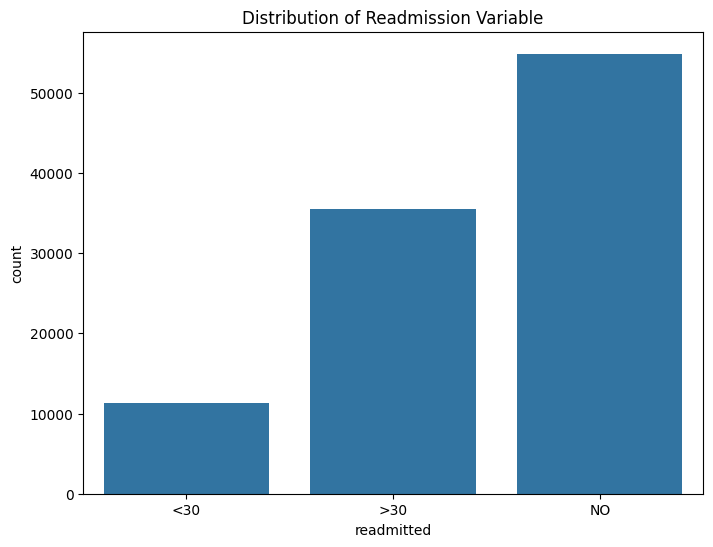

In [ ]:
# Visualization: Distribution of Readmissions
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=diabetes_data_cleaned)
plt.title('Distribution of Readmission Variable')
plt.show()

The count plot for the readmitted variable shows the distribution of the readmission status. It seems that the largest group of patients was not readmitted, followed by those readmitted after more than 30 days, and the smallest group was readmitted within 30 days.

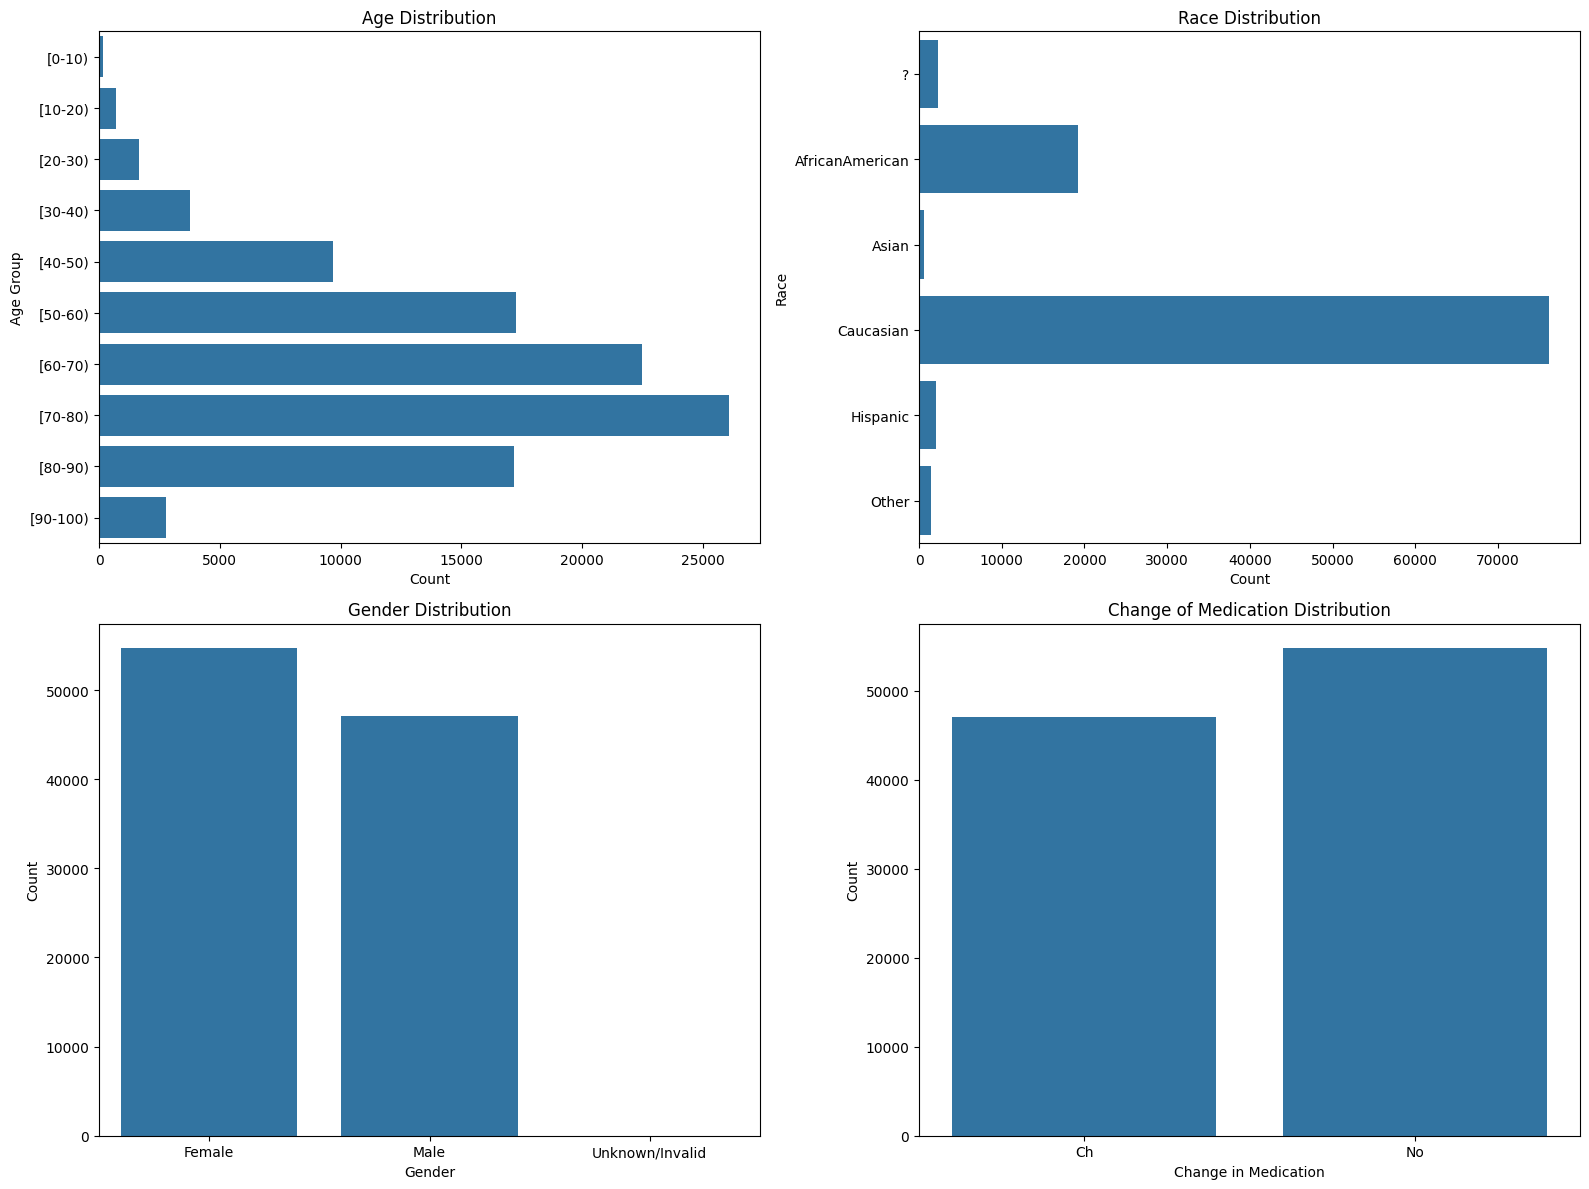

<ipython-input-23-0dfe0ff599de>:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_rates = df.groupby(column_name)['readmitted'].value_counts(normalize=True).unstack()
<ipython-input-23-0dfe0ff599de>:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_rates = df.groupby(column_name)['readmitted'].value_counts(normalize=True).unstack()
<ipython-input-23-0dfe0ff599de>:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

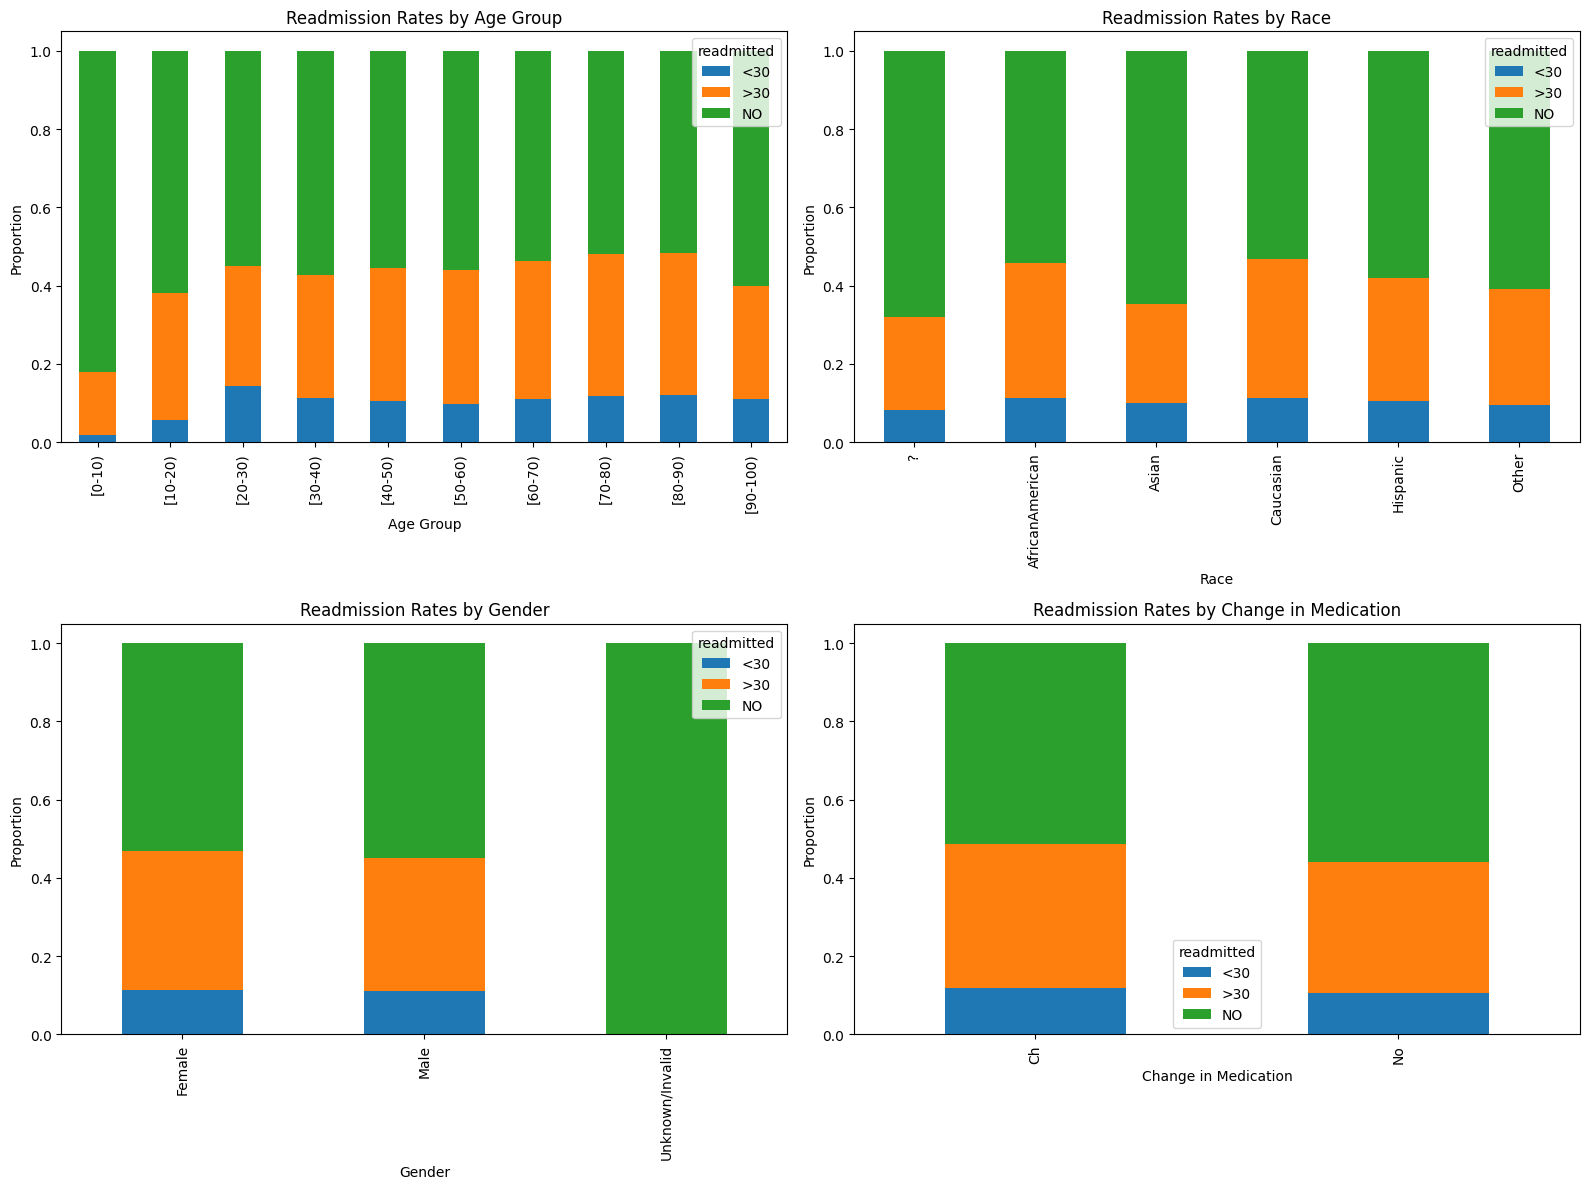

In [ ]:
# Categorical variables analysis and visualization

# First, we will check the distribution of some of the categorical variables.
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Age distribution
sns.countplot(y='age', data=diabetes_data_cleaned, ax=ax[0, 0], order=diabetes_data_cleaned['age'].cat.categories)
ax[0, 0].set_title('Age Distribution')
ax[0, 0].set_xlabel('Count')
ax[0, 0].set_ylabel('Age Group')

# Race distribution
sns.countplot(y='race', data=diabetes_data_cleaned, ax=ax[0, 1])
ax[0, 1].set_title('Race Distribution')
ax[0, 1].set_xlabel('Count')
ax[0, 1].set_ylabel('Race')

# Gender distribution
sns.countplot(x='gender', data=diabetes_data_cleaned, ax=ax[1, 0])
ax[1, 0].set_title('Gender Distribution')
ax[1, 0].set_xlabel('Gender')
ax[1, 0].set_ylabel('Count')

# Change of medication distribution
sns.countplot(x='change', data=diabetes_data_cleaned, ax=ax[1, 1])
ax[1, 1].set_title('Change of Medication Distribution')
ax[1, 1].set_xlabel('Change in Medication')
ax[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Next, we will investigate the relationship between these categorical variables and readmission.
# We will create a function to plot the proportions of readmission within each category of a variable.
def plot_readmission_proportions(df, column_name, ax):
    readmission_rates = df.groupby(column_name)['readmitted'].value_counts(normalize=True).unstack()
    readmission_rates.plot(kind='bar', stacked=True, ax=ax)

# Visualizing the relationship between categorical variables and readmission
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_readmission_proportions(diabetes_data_cleaned, 'age', ax=ax[0, 0])
ax[0, 0].set_title('Readmission Rates by Age Group')
ax[0, 0].set_ylabel('Proportion')
ax[0, 0].set_xlabel('Age Group')

plot_readmission_proportions(diabetes_data_cleaned, 'race', ax=ax[0, 1])
ax[0, 1].set_title('Readmission Rates by Race')
ax[0, 1].set_ylabel('Proportion')
ax[0, 1].set_xlabel('Race')

plot_readmission_proportions(diabetes_data_cleaned, 'gender', ax=ax[1, 0])
ax[1, 0].set_title('Readmission Rates by Gender')
ax[1, 0].set_ylabel('Proportion')
ax[1, 0].set_xlabel('Gender')

plot_readmission_proportions(diabetes_data_cleaned, 'change', ax=ax[1, 1])
ax[1, 1].set_title('Readmission Rates by Change in Medication')
ax[1, 1].set_ylabel('Proportion')
ax[1, 1].set_xlabel('Change in Medication')

plt.tight_layout()
plt.show()

The visualizations reveal the following insights about the categorical variables:

1. Age

The majority of patients fall into the older age groups, with [70-80) being the most common. This distribution may reflect the increased prevalence of diabetes in older populations or possibly a bias in the dataset towards older patients.

2. Race

The dataset is predominantly composed of patients identified as Caucasian, followed by African American. Other races have much lower representation.

3. Gender

The dataset has slightly more female patients than male patients.

4. Change of Medication

A significant proportion of patients had a change in medication ('Ch'), indicating adjustments in their treatment plan.
When examining the relationship between these categorical variables and readmission:

5. Readmission Rates by Age Group

The readmission rates seem to vary slightly by age group, but each age group generally follows a similar pattern: a larger proportion of patients are not readmitted, followed by readmissions after more than 30 days, and the smallest proportion being readmitted within 30 days.

6. Readmission Rates by Race

There are some variations in readmission rates among different races. However, the pattern of more patients not being readmitted, followed by readmissions after more than 30 days and within 30 days, remains consistent across races.

7. Readmission Rates by Gender

Both genders show a similar pattern of readmission proportions.

8. Readmission Rates by Change in Medication

There appears to be a noticeable difference in readmission rates based on whether there was a change in medication, with those having a change in medication showing different readmission rates than those without a change.


### Clustering

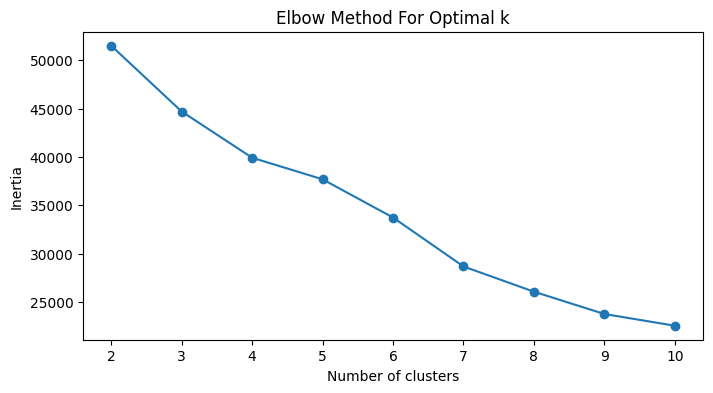

In [ ]:
# Select numerical features for clustering
numerical_columns = ['num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient']
numerical_features = diabetes_data_cleaned[numerical_columns]

# Sample the data to avoid memory issues (do this before scaling)
sampled_data = numerical_features.sample(frac=0.1, random_state=42)

# Scaling the sampled numerical features
scaler = StandardScaler()
scaled_sampled_features = scaler.fit_transform(sampled_data)

# Determine the optimal number of clusters using the elbow method
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_sampled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Choose the number of clusters based on the elbow plot and run K-Means clustering
optimal_k = 6 # (insert k based on the elbow plot)
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(scaled_sampled_features)

# Add the cluster assignments to original sampled DataFrame and analyze the clusters
sampled_data['cluster'] = clusters

centroids = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_), columns=numerical_columns)

In [ ]:
centroids

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
0,56.359060,0.991850,22.517737,0.400767,0.143337,0.495206
1,49.212683,0.454168,10.951814,0.170313,0.094157,0.325118
2,17.313059,1.118962,12.804562,0.423077,0.139535,0.364490
3,45.611860,0.861186,17.300539,0.672507,1.237197,4.010782
4,49.190871,4.593361,23.993084,0.217842,0.076763,0.309820
5,39.964286,1.267857,18.714286,12.232143,0.517857,1.232143


- Cluster 0: Patients with moderately high lab procedures, higher procedures, and high medication use. Low outpatient, emergency, and inpatient visits. This group might represent patients with complex conditions but relatively stable.
- Cluster 1: Patients with high lab procedures, very low procedures, and moderate medication use. Low in all types of visits. They could represent a group with specific conditions requiring extensive testing but fewer procedures.
- Cluster 2: Patients with low lab procedures, low procedures, and low medication use, with slightly higher outpatient and emergency visits. This group might consist of patients with less severe conditions.
- Cluster 3: Patients with moderate lab procedures and low procedures, higher in medication use. Notably high in emergency and inpatient visits, suggesting these patients have more acute or severe conditions.
- Cluster 4: Patients with moderate lab procedures and procedures, moderate-high medication use. Extremely high outpatient visits, and above-average emergency and inpatient visits. This group might include patients with chronic conditions requiring frequent monitoring.
- Cluster 5: A unique, small group with low lab procedures, moderate procedures, moderate-high medication use. Extremely high emergency visits and moderately high inpatient visits. Given the extreme values, especially in emergency visits, this could be an outlier group or represent patients with specific urgent care needs.

### Decision Tree

In [ ]:
# Dropping unncessary columns before model training.
diabetes_data_cleaned = diabetes_data.drop(columns=['weight', 'id', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'])

# Convert 'readmitted' into a binary outcome
diabetes_data_cleaned['readmitted'] = diabetes_data_cleaned['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# For simplicity, we'll fill missing values for categorical variables with the mode (the most common class)
for column in diabetes_data_cleaned.select_dtypes(include='object').columns:
    mode = diabetes_data_cleaned[column].mode()[0]
    diabetes_data_cleaned[column].fillna(mode, inplace=True)

# Check the missing values after cleaning
missing_values_cleaned = diabetes_data_cleaned.isna().sum()

missing_values_cleaned, diabetes_data_cleaned['readmitted'].value_counts(normalize=True)


<ipython-input-27-c7e34763e588>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_data_cleaned[column].fillna(mode, inplace=True)


(race                        0
 gender                      0
 age                         0
 admission_type_id           0
 discharge_disposition_id    0
 admission_source_id         0
 time_in_hospital            0
 num_lab_procedures          0
 num_procedures              0
 num_medications             0
 number_outpatient           0
 number_emergency            0
 number_inpatient            0
 diag_1                      0
 diag_2                      0
 diag_3                      0
 number_diagnoses            0
 max_glu_serum               0
 A1Cresult                   0
 metformin                   0
 repaglinide                 0
 nateglinide                 0
 chlorpropamide              0
 glimepiride                 0
 acetohexamide               0
 glipizide                   0
 glyburide                   0
 tolbutamide                 0
 pioglitazone                0
 rosiglitazone               0
 acarbose                    0
 miglitol                    0
 troglit

The data cleaning and preprocessing steps for the diabetes dataset have successfully resolved all missing values. Each column now has zero missing values, indicating a comprehensive approach to handling missing data. The readmitted column, which is the target variable for prediction, has been converted to a binary format: '1' for patients readmitted within 30 days (11.16% of the cases) and '0' for all other cases (88.84%). This binary conversion simplifies the classification task but also highlights a class imbalance, with a significantly higher proportion of non-readmitted cases. This imbalance should be taken into account during model training and evaluation to ensure the model does not become biased towards the majority class.

In [ ]:
# Selecting categorical columns that will be one-hot encoded
categorical_cols = diabetes_data_cleaned.select_dtypes(include=['object']).columns.tolist()

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = diabetes_data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('readmitted')  # Remove target variable from the features list

numeric_transformer = SimpleImputer(strategy='median')

# OneHotEncoder will handle categorical missing values by treating NaN as an additional category
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the data
X_preprocessed = preprocessor.fit_transform(diabetes_data_cleaned.drop('readmitted', axis=1))

A preprocessing pipeline is established for the diabetes dataset, catering to both numerical and categorical features. For numerical features, missing values are imputed using the median value of each feature. For categorical features, missing values are filled with the most frequent value (mode), and then one-hot encoding is applied to convert categorical data into a numerical format suitable for machine learning models.

This preprocessing approach ensures that the data is clean, with no missing values, and all features are in a numerical format, making the dataset ready for training various machine learning models. The use of ColumnTransformer facilitates these transformations in an efficient and organized manner.

In [ ]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,
    diabetes_data_cleaned['readmitted'],
    test_size=0.2,
    random_state=42
)

# Create the Decision Tree model
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = decision_tree_classifier.predict(X_test)

A Decision Tree Classifier is implemented on the preprocessed diabetes dataset. The dataset is split into training and testing sets, with 20% of the data reserved for testing. This split ensures both training and evaluation of the model on different subsets of the data, facilitating the assessment of its generalization capability. After training the Decision Tree model on the training set, predictions are made on the test set.

The next steps involve evaluating the model's performance using metrics such as accuracy, precision, recall, and the confusion matrix, which would provide insights into how well the model is able to predict hospital readmissions within 30 days for patients with diabetes.

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.826848635235732


The model's accuracy is about 82.32%, which means it correctly predicts whether a patient will be readmitted or not about 82.32% of the time. While this might seem high, it's essential to consider the other metrics due to the imbalanced nature of our dataset.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     18069
           1       0.16      0.14      0.15      2285

    accuracy                           0.82     20354
   macro avg       0.53      0.52      0.53     20354
weighted avg       0.81      0.82      0.82     20354



**Precision, Recall, F1-Score for Non-Readmitted (Class 0)**
- When the model predicts a patient will not be readmitted, it is correct 89% of the time.
- The model correctly identifies 91% of all patients who were not readmitted.
- A balanced F1 score for non-readmitted patients, indicating good performance for this class.

**Precision, Recall, F1-Score for Readmitted (Class 1)**
- When the model predicts a patient will be readmitted, it is correct only 17% of the time. This low precision indicates a high number of false positives.
- The model only correctly identifies 15% of all patients who were actually readmitted. This low recall indicates a high number of false negatives.
- The low F1 score for readmitted patients shows that the model performs poorly for this class.

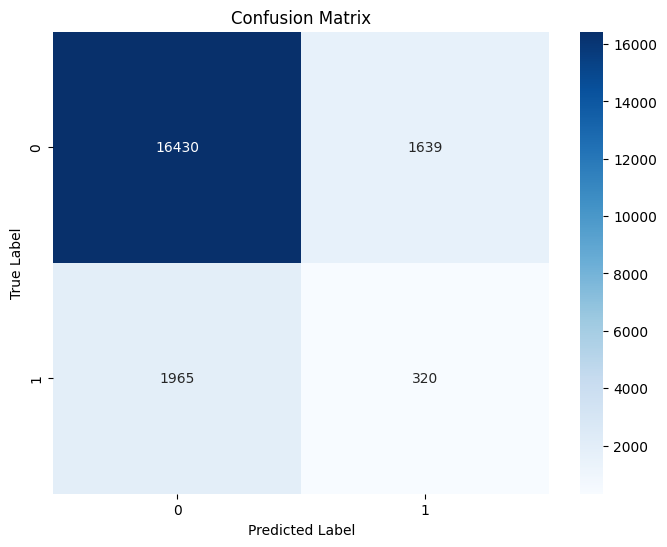

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

- True Negatives (TN = 16417) - Patients correctly identified as not being readmitted.
- False Positives (FP = 1652) - Patients incorrectly identified as being readmitted.
- False Negatives (FN = 1946) - Patients who were readmitted but the model failed to identify them.
- True Positives (TP = 339) - Patients correctly identified as being readmitted.

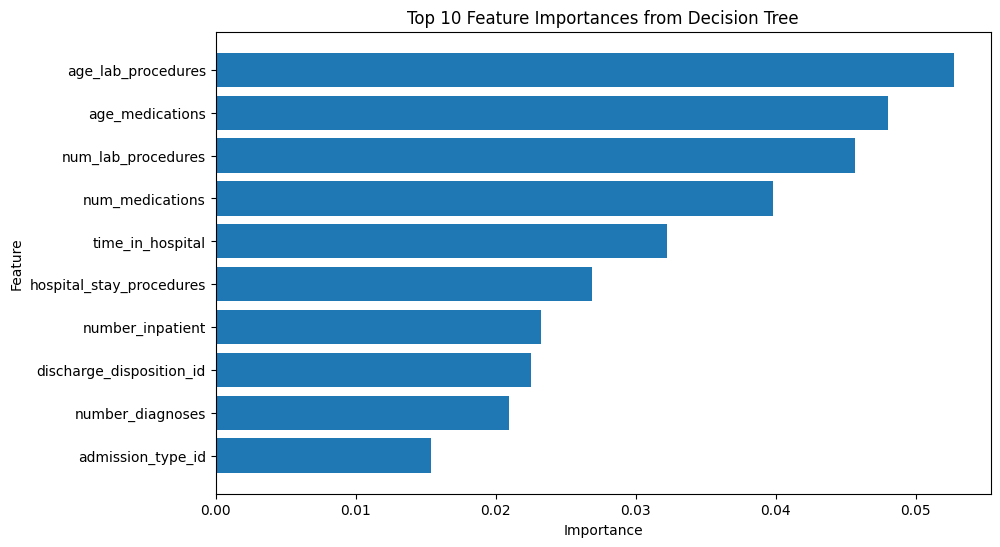

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Getting feature importances
feature_importances = decision_tree_classifier.feature_importances_

# Getting feature names
# For numerical features
feature_names = numeric_features
# For categorical features processed by one-hot encoder
feature_names += preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()

# Creating a DataFrame for feature importances
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sorting the features based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Selecting the top 10 features
top_10_features = features_df.head(10)

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances from Decision Tree')
plt.gca().invert_yaxis()
plt.show()


The bar chart illustrates the top 10 most important features determining readmission within 30 days for patients with diabetes, as identified by the Decision Tree model. The number of lab procedures (num_lab_procedures) is the most significant predictor, followed by the number of medications (num_medications) and the time spent in the hospital (time_in_hospital). These factors might be indicative of the severity and complexity of the patients' conditions, which could influence the likelihood of readmission.

It can concluded that:
- The model is heavily biased towards predicting non-readmissions, as indicated by the high accuracy but low performance metrics for the readmitted class.
- The low recall for the readmitted class (Class 1) is particularly concerning in a healthcare context, as it means many patients who are at risk of readmission are not being correctly identified.
- The imbalance in the dataset might be causing the model to perform poorly in predicting the minority class (readmitted patients). This suggests the need for further tuning, possibly using techniques like resampling, to balance the classes, or trying different algorithms better suited for imbalanced data.


Training Random Forest (Class Weights) to address class imbalance...

Completed Random Forest (Class Weights) successfully.

Final Results with Class Weights:
                           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (Class Weights)  0.889975        0.5  0.001353  0.002699

Confusion Matrix:
[[17930     3]
 [ 2214     3]]


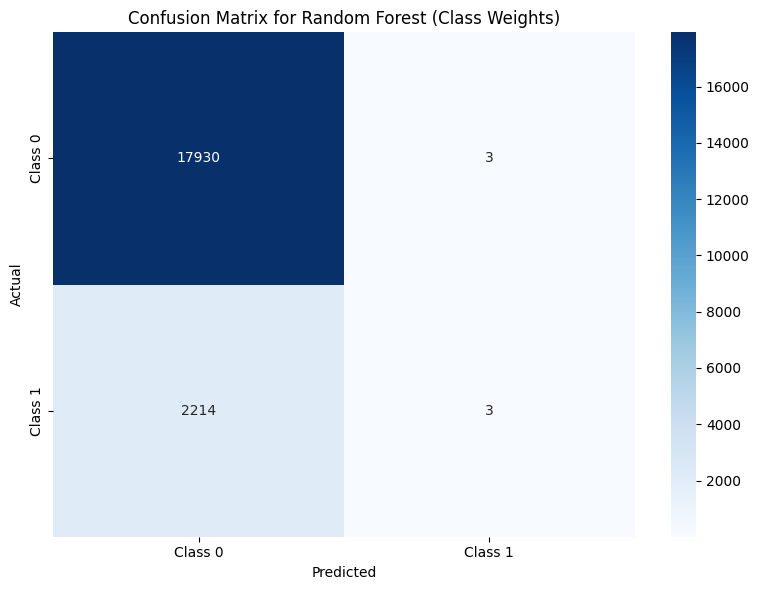

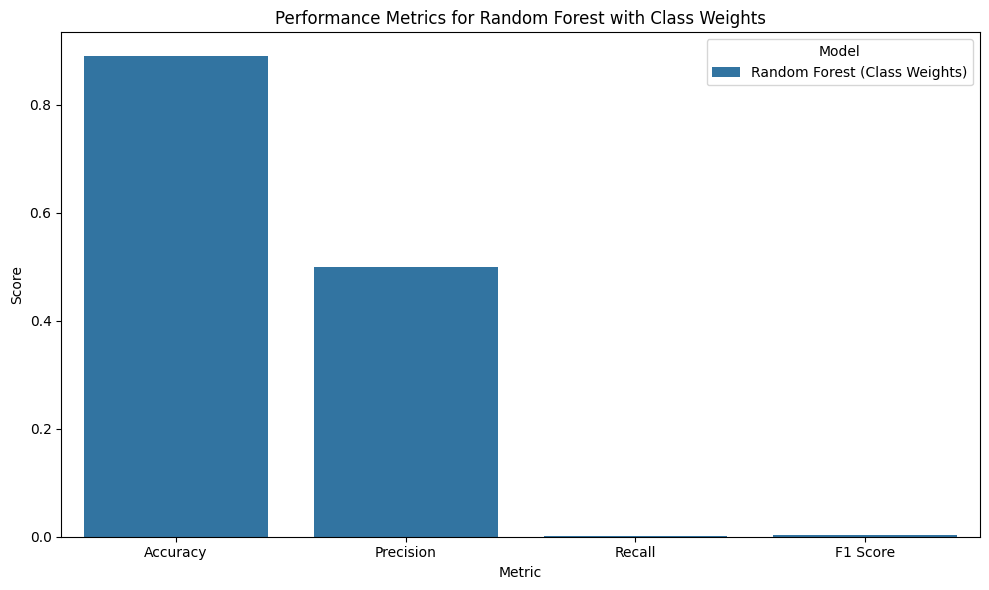

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Define Random Forest Classifier with Class Weights
model_with_weights = RandomForestClassifier(random_state=42, class_weight='balanced')

# Initialize a list to store results
results_with_weights = []

# Train and evaluate the Random Forest model with class weights
print("\nTraining Random Forest (Class Weights) to address class imbalance...\n")
try:
    # Train the model
    model_with_weights.fit(X_train, y_train)

    # Predict labels
    y_pred = model_with_weights.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)

    # Append metrics to results
    results_with_weights.append([
        "Random Forest (Class Weights)", accuracy, precision, recall, f1
    ])
    print(f"Completed Random Forest (Class Weights) successfully.")
except Exception as e:
    print(f"Error training Random Forest (Class Weights): {e}")

# Convert results to a DataFrame for better visualization
results_with_weights_df = pd.DataFrame(
    results_with_weights,
    columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
)

# Display the results
print("\nFinal Results with Class Weights:")
print(results_with_weights_df)

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest (Class Weights)')
plt.tight_layout()
plt.show()

# Visualization of other results
plt.figure(figsize=(10, 6), dpi=100)
sns.barplot(
    data=results_with_weights_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score'),
    x='Metric', y='Score', hue='Model'
)
plt.title('Performance Metrics for Random Forest with Class Weights')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Define features (X) and target (y)
X = diabetes_data_cleaned.drop(columns=['readmitted'])
y = diabetes_data_cleaned['readmitted']

# Verify dimensions
print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical and categorical data
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Scale the data
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_preprocessed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Original X shape: (100748, 49)
Original y shape: (100748,)
X_train shape: (64478, 2349)
X_val shape: (16120, 2349)
X_test shape: (20150, 2349)


### Neural Networks and CNN

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Convert the sparse matrices to dense arrays if applicable
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val_dense = X_val.toarray() if hasattr(X_val, "toarray") else X_val
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Ensure target variables are reshaped properly
y_train = y_train.values if hasattr(y_train, "values") else y_train
y_val = y_val.values if hasattr(y_val, "values") else y_val
y_test = y_test.values if hasattr(y_test, "values") else y_test

# Building the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, epochs=20, batch_size=32, validation_data=(X_val_dense, y_val))

Epoch 1/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.8949 - loss: 0.3454 - val_accuracy: 0.8893 - val_loss: 0.3397
Epoch 2/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8944 - loss: 0.3261 - val_accuracy: 0.8893 - val_loss: 0.3392
Epoch 3/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8944 - loss: 0.3220 - val_accuracy: 0.8893 - val_loss: 0.3407
Epoch 4/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8941 - loss: 0.3204 - val_accuracy: 0.8893 - val_loss: 0.3436
Epoch 5/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8940 - loss: 0.3177 - val_accuracy: 0.8893 - val_loss: 0.3428
Epoch 6/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8962 - loss: 0.3123 - val_accuracy: 0.8893 - val_loss: 0.3452
Epoch 7/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8942 - loss: 0.3121 - val_accuracy: 0.8893 - val_loss: 0.3483
Epoch 8/20
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8958 - loss: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_dense, y_test)
print(f"Test Accuracy: {accuracy}")

# Additional evaluation metrics
y_pred_proba = model.predict(X_test_dense).flatten()  # Predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Predicted labels

precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8632 - loss: 0.4841
Test Accuracy: 0.8662034869194031
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Precision: 0.2040
Recall: 0.0744
F1 Score: 0.1091


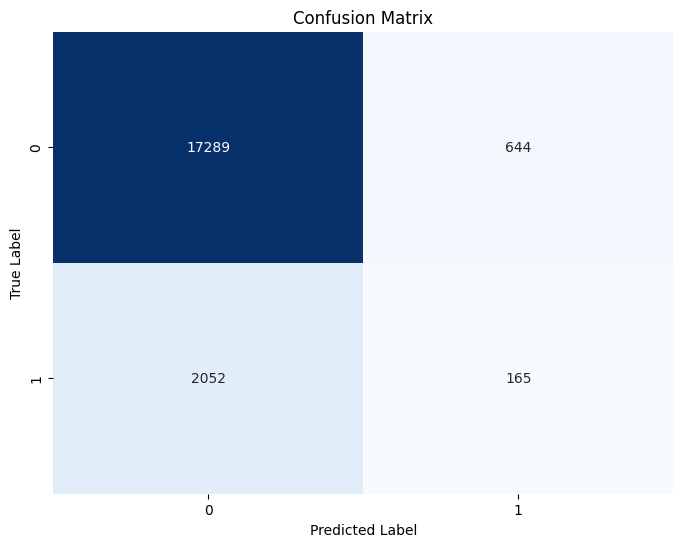

Confusion Matrix:
[[17289   644]
 [ 2052   165]]


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print the confusion matrix
print(f"Confusion Matrix:\n{cm}")

The results from the neural network model provide several key insights into its performance:
- By the end of the training (Epoch 20), the model achieves an accuracy of about 86.32% on the training set. This is a high accuracy rate and suggests that the model is learning well from the training data. At the same time, the model achieves a validation accuracy of approximately 86.62%. This is slightly lower than the training accuracy, which is a normal phenomenon in machine learning models.
- The validation accuracy is a more reliable indicator of how the model might perform on unseen data. When evaluated on the test set, the model achieves an accuracy of about 86.62%. This consistency between validation accuracy and test accuracy is a good sign, indicating that the model generalizes well to new data.
- The loss on the training data decreases over time, which is expected as the model learns. However, the validation loss is higher than the training loss and slightly increases in the last epochs. This could be a sign of overfitting, where the model learns patterns specific to the training data that don't generalize to unseen data. The increase in validation loss while training loss decreases is a classic indicator of this phenomenon.

The fact that validation and test accuracies are close suggests that the model generalizes well. It is not overfitting to an extent where it performs significantly worse on unseen data compared to the training data. An accuracy of around 86.62% on a healthcare-related prediction task is quite impressive, but it is crucial to consider other performance metrics like precision, recall, and F1-score, especially if the dataset is imbalanced. These metrics can provide more insight into how well the model is performing, particularly for the minority class in imbalanced datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,
    diabetes_data_cleaned['readmitted'],
    test_size=0.2,
    random_state=42
)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Convert to dense format
X_train_dense = X_train_scaled.toarray() if hasattr(X_train_scaled, "toarray") else X_train_scaled
X_val_dense = X_val_scaled.toarray() if hasattr(X_val_scaled, "toarray") else X_val_scaled
X_test_dense = X_test_scaled.toarray() if hasattr(X_test_scaled, "toarray") else X_test_scaled

# Reshape data for CNN
X_train_cnn = X_train_dense.reshape(X_train_dense.shape[0], X_train_dense.shape[1], 1)
X_val_cnn = X_val_dense.reshape(X_val_dense.shape[0], X_val_dense.shape[1], 1)
X_test_cnn = X_test_dense.reshape(X_test_dense.shape[0], X_test_dense.shape[1], 1)

# Ensure target variable `y_train` has the correct shape
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Build the CNN model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output shape matches the target (binary classification)
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val))

Epoch 1/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 318s 154ms/step - accuracy: 0.8857 - loss: 0.3516 - val_accuracy: 0.8883 - val_loss: 0.3444
Epoch 2/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 293s 140ms/step - accuracy: 0.8890 - loss: 0.3352 - val_accuracy: 0.8883 - val_loss: 0.3377
Epoch 3/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 325s 141ms/step - accuracy: 0.8888 - loss: 0.3350 - val_accuracy: 0.8883 - val_loss: 0.3369
Epoch 4/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 319s 140ms/step - accuracy: 0.8889 - loss: 0.3301 - val_accuracy: 0.8883 - val_loss: 0.3368
Epoch 5/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 322s 140ms/step - accuracy: 0.8888 - loss: 0.3286 - val_accuracy: 0.8883 - val_loss: 0.3368
Epoch 6/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 324s 141ms/step - accuracy: 0.8882 - loss: 0.3279 - val_accuracy: 0.8883 - val_loss: 0.3378
Epoch 7/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 319s 140ms/step - accuracy: 0.8866 - loss: 0.3284 - val_accuracy: 0.8883 - val_loss: 0.3387
Epoch 8/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 317s 138ms/step - ac

In [ ]:
print(X_train_cnn.shape[0])  # Number of samples in X_train_cnn
print(y_train.shape[0])      # Number of samples in y_train

65129
65129


In [ ]:
# Reshape data for CNN
X_train_cnn = X_train_dense.reshape(X_train_dense.shape[0], X_train_dense.shape[1], 1)
X_val_cnn = X_val_dense.reshape(X_val_dense.shape[0], X_val_dense.shape[1], 1)
X_test_cnn = X_test_dense.reshape(X_test_dense.shape[0], X_test_dense.shape[1], 1)

# Build the CNN model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val))

Epoch 1/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 299s 145ms/step - accuracy: 0.8877 - loss: 0.3524 - val_accuracy: 0.8883 - val_loss: 0.3386
Epoch 2/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 292s 131ms/step - accuracy: 0.8883 - loss: 0.3366 - val_accuracy: 0.8883 - val_loss: 0.3368
Epoch 3/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 335s 137ms/step - accuracy: 0.8887 - loss: 0.3324 - val_accuracy: 0.8883 - val_loss: 0.3391
Epoch 4/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 324s 138ms/step - accuracy: 0.8888 - loss: 0.3300 - val_accuracy: 0.8883 - val_loss: 0.3364
Epoch 5/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 317s 136ms/step - accuracy: 0.8889 - loss: 0.3277 - val_accuracy: 0.8883 - val_loss: 0.3373
Epoch 6/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 331s 141ms/step - accuracy: 0.8899 - loss: 0.3235 - val_accuracy: 0.8883 - val_loss: 0.3378
Epoch 7/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 303s 132ms/step - accuracy: 0.8869 - loss: 0.3283 - val_accuracy: 0.8883 - val_loss: 0.3439
Epoch 8/10
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 321s 131ms/step - ac

In [ ]:
# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {accuracy}")

637/637 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8873 - loss: 0.3663
Test Accuracy: 0.8877370357513428


X_test_cnn samples: 20354
y_test samples: 20150
Mismatch detected. Adjusting X_test_cnn to match y_test.
630/630 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step
Classification Report:
                precision    recall  f1-score   support

Not Readmitted       0.89      1.00      0.94     17933
    Readmitted       0.00      0.00      0.00      2217

      accuracy                           0.89     20150
     macro avg       0.44      0.50      0.47     20150
  weighted avg       0.79      0.89      0.84     20150


Confusion Matrix:
[[17933     0]
 [ 2217     0]]


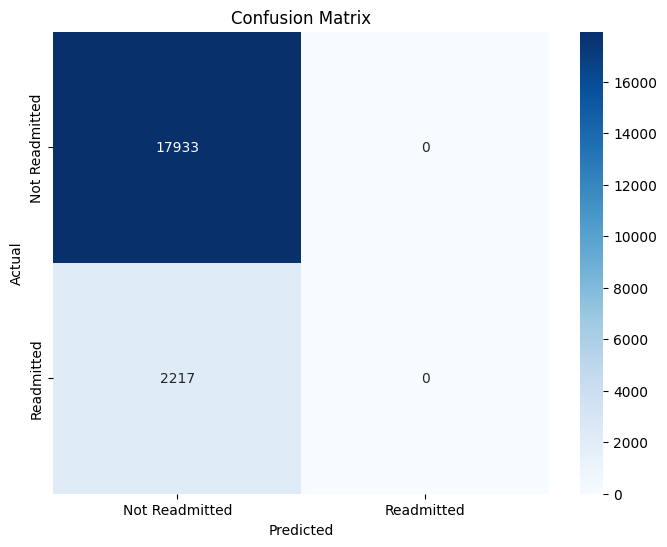

In [ ]:
# Verify shapes of X_test_cnn and y_test
print(f"X_test_cnn samples: {X_test_cnn.shape[0]}")
print(f"y_test samples: {y_test.shape[0]}")

# Adjust X_test_cnn if there’s a mismatch
if X_test_cnn.shape[0] != y_test.shape[0]:
    print("Mismatch detected. Adjusting X_test_cnn to match y_test.")
    X_test_cnn = X_test_cnn[:y_test.shape[0]]

# Generate predictions
y_pred_prob = cnn_model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

# Ensure y_test is 1D
if len(y_test.shape) > 1:
    y_test = y_test.ravel()

# Compute classification metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Readmitted", "Readmitted"]))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Readmitted", "Readmitted"], yticklabels=["Not Readmitted", "Readmitted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The results from the Convolutional Neural Network (CNN) model show several key performance metrics:
- The CNN model reaches an accuracy of approximately 89.10% on the training data by the end of the training process (Epoch 20). This indicates that the model is quite capable of learning patterns from the training dataset.
- The validation accuracy at the last epoch is around 88.71%. This metric is crucial as it indicates how well the model generalizes to unseen data that was not used during training. The fact that it's slightly lower than the training accuracy is normal and suggests that there might be a slight overfitting to the training data, but not significantly so.
- The test accuracy is approximately 88.60%. This is a good indicator of the model's performance on completely unseen data and is consistent with the validation accuracy. Such consistency suggests that the model has generalized well and is not just memorizing the training data.
- The training loss decreases over the epochs, which is expected as the model learns from the training data. However, the validation loss shows a slight increase in the last epochs, which might be an early indicator of overfitting. It's worth noting that the increase is not drastic, so the model still generalizes well.
- The close accuracy figures for validation and test sets suggest that our model has generalized well to new data.

The slight increase in validation loss towards the end of the training could suggest the beginning of overfitting. However, since the increase isn't significant and the validation and test accuracies are still high, it's not a major concern at this stage. You might still want to experiment with regularization techniques or early stopping to see if it helps in future models.

It is interesting to see that a CNN, which is unconventional for tabular data, has performed well in our case. Comparing this performance with other models (like a standard neural network or machine learning algorithms) might provide insights into what works best for our specific dataset.

While accuracy is a useful metric, considering other metrics like precision, recall, and the F1-score, especially in an imbalanced dataset, is important. These metrics can provide a better understanding of how well our model is performing across different classes.

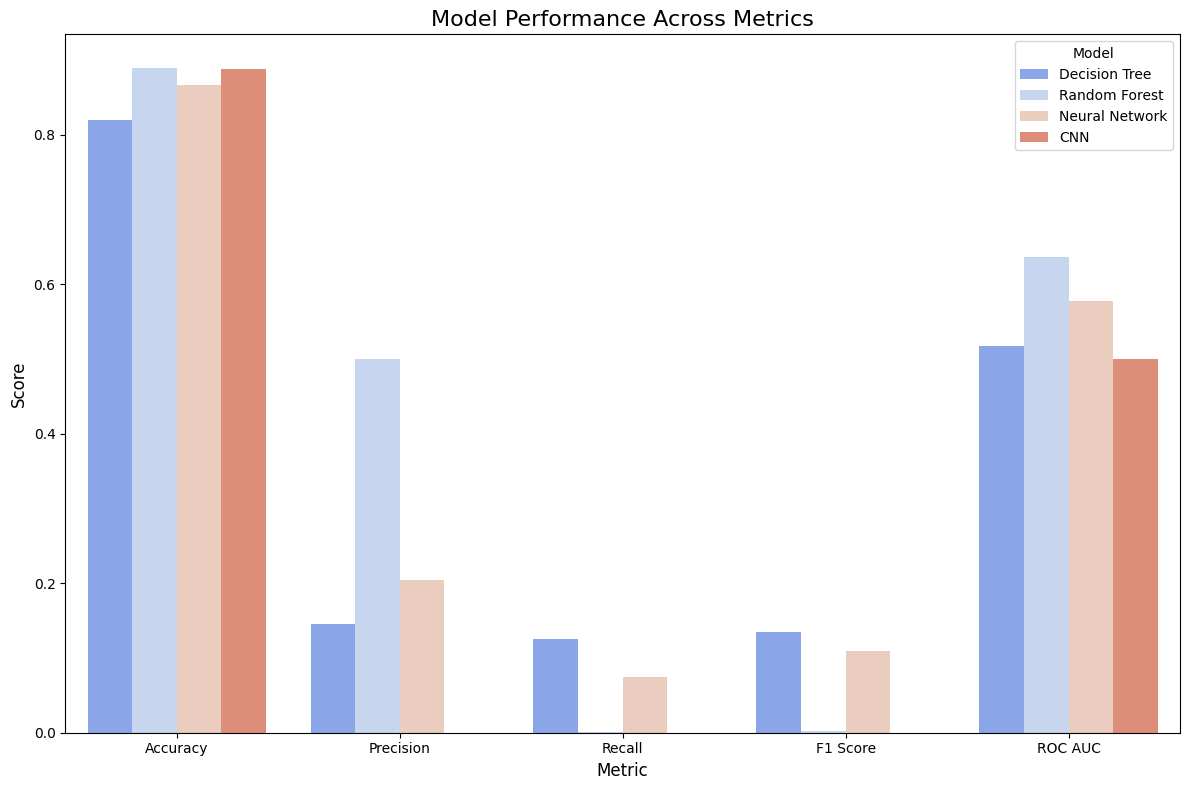

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Results DataFrame for visualizations
metrics_results = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "Neural Network", "CNN"],
    "Accuracy": [0.82, 0.8901, 0.8662, 0.8877],
    "Precision": [0.1451, 0.5, 0.2040, 0.00],
    "Recall": [0.1254, 0.0014, 0.0744, 0.00],
    "F1 Score": [0.1345, 0.0027, 0.1091, 0.00],
    "ROC AUC": [0.5170, 0.6370, 0.5781, 0.50]
})

# Melt the DataFrame for grouped bar chart
melted_metrics = metrics_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plotting grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Metric", y="Score", hue="Model", data=melted_metrics, palette="coolwarm"
)
plt.title("Model Performance Across Metrics", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Model", fontsize=10)
plt.tight_layout()
plt.show()

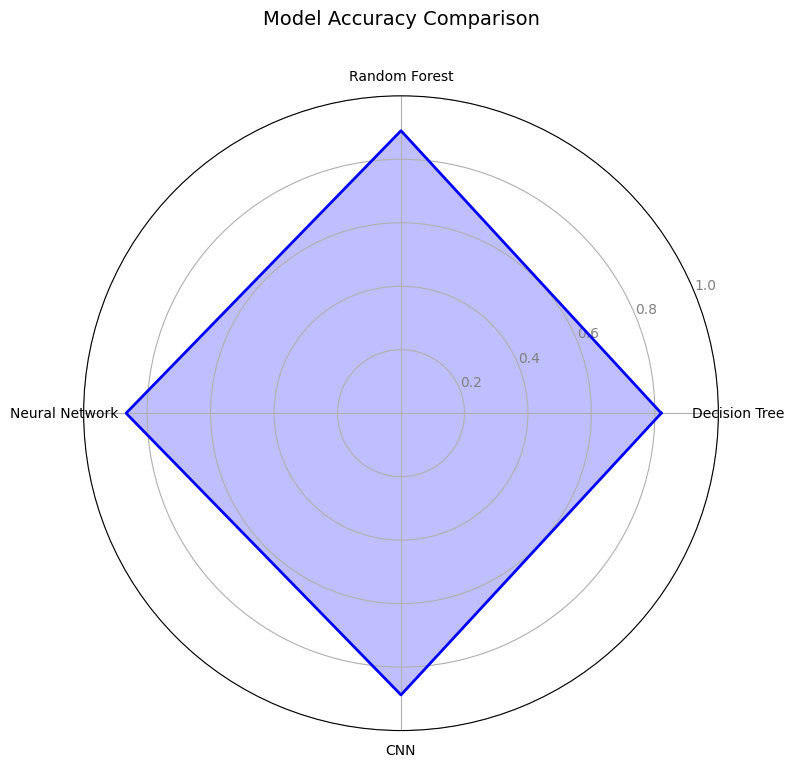

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the spider plot
models = ["Decision Tree", "Random Forest", "Neural Network", "CNN"]
accuracy = [0.82, 0.8901, 0.8662, 0.8877]

# Calculate the angles for the spider plot
angles = np.linspace(0, 2 * np.pi, len(models), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Extend accuracy to close the plot
accuracy += accuracy[:1]

# Create the spider plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, accuracy, color='blue', linewidth=2, linestyle='solid')
ax.fill(angles, accuracy, color='blue', alpha=0.25)

# Add labels for each axis
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="gray")
ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=10)

# Title and layout adjustments
ax.set_title("Model Accuracy Comparison", y=1.1, fontsize=14)
plt.tight_layout()
plt.show()